In [ ]:
# default_exp train

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

以 所有phase数据中 在test中的user_id的最后一次点击作为 线下验证集

这样做的好处是尽量减少训练的时间

val要打印每个phase的评分，总评分，总评分/phase_num

In [2]:
# export
import os
import sys
sys.path.append('../mylib/')
from algo.rs.matrix import *
from code.val import main as val
from code.eda import * 
from code.config import args
import pandas as pd  
import numpy as np
from tqdm import tqdm  
from collections import defaultdict  
import math  
from sklearn.metrics.pairwise import cosine_similarity
from loguru import logger


In [3]:

trace = logger.add(os.path.join(args.DATA_DIR, 'data_gen/runtime.log'))  

# recall methods

## recall_from_cocur_matr

In [4]:
# export
def recall_from_cocur_matr(matr, topk, user_pred_list, user_items, item2id, id2item):
    """
    
    :item_list: 
    """
    rs = pd.Series()
    from multiprocessing.dummy import Pool
    pool = Pool()
    def t(u):
#         items = user_items[u][-30:]
        items = user_items[u]
        len_items = len(items)
#         print(len_items)
        sr = pd.Series()
        for i, item in enumerate(items):
#             sr = sr.append(pd.Series(matr[item2id[item]].toarray()[0]).sort_values()[-100:] * (len_items+i))
            sr = sr.append(pd.Series(matr[item2id[item]].toarray()[0]).sort_values()[-500:] * (len_items//2+1+i))
        sr = sr.reset_index()
        sr.columns = ['id', 'score']

        sr = sr.groupby('id')['score'].sum().reset_index()
        sr['item_id'] = sr['id'].map(id2item)
        
        sr = sr[~sr.item_id.isin(user_items[u])]
        
#         rs.loc[u] = sr.sort_values('score', ascending=False)[:topk]['item_id score'.split()].values.tolist()
        return u, sr.sort_values('score', ascending=False)[:topk]['item_id score'.split()].values.tolist()
    rs = pool.map(t, user_pred_list)
    rs = pd.Series(dict(rs))
    return rs

## recall_from_bipartite_network

In [32]:
def recall_from_bipartite_network(df,test_qtime, user_col, item_col):  
    user_item_ = df.groupby(user_col)[item_col].agg(set).reset_index()  
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))  
    
    item_user_ = df.groupby(item_col)[user_col].agg(set).reset_index()  
    item_user_dict = dict(zip(item_user_[item_col], item_user_[user_col]))    

    item_cnt = defaultdict(int)  
    for user, items in tqdm(user_item_dict.items()):  
        for i in items:  
            item_cnt[i] += 1  

    sim_item = {}

    for item, users in tqdm(item_user_dict.items()):
    
        sim_item.setdefault(item, {}) 
    
        for u in users:
        
            tmp_len = len(user_item_dict[u])
        
            for relate_item in user_item_dict[u]:
                sim_item[item].setdefault(relate_item, 0)
                sim_item[item][relate_item] += 1/ (math.log(len(users)+1) * math.log(tmp_len+1))

    def recommend(sim_item_corr, user_item_dict, user_id, top_k):  
        rank = {}  
        interacted_items = user_item_dict[user_id]  
        for i in interacted_items:  
            for j, wij in sorted(sim_item_corr[i].items(), key=lambda d: d[1], reverse=True)[0:100]:  
                if j not in interacted_items:  
                    rank.setdefault(j, 0)  
                    rank[j] += wij  
        return sorted(rank.items(), key=lambda d: d[1], reverse=True)[:top_k]  

    recom_item = []        
    for i in tqdm(test_qtime['user_id'].unique()):  
        rank_item = recommend(sim_item, user_item_dict , i, args.topk)  
        for j in rank_item:  
            recom_item.append([i, j[0], j[1]])  # user_id, item_id, sim                
    
    dfr = pd.DataFrame(recom_item)

    dfr.columns = 'user_id item_id score'.split()
    dfr['item_id_score'] = dfr.item_id.map(lambda x: [x]) + dfr.score.map(lambda x: [x])
    srr = dfr.sort_values('score', ascending=False).groupby('user_id')['item_id_score'].agg(list)
            
    return srr

In [65]:
user_feat = pd.read_pickle(os.path.join(DATA_DIR, 'data_gen/user_feat.pkl'))

user_feat_inv = pd.read_pickle(os.path.join(DATA_DIR, 'data_gen/user_feat_inv.pkl'))

In [3]:
# export

# topk=100

def recall_from_user_feat(user_items):
    """
    找出特征相同的用户做推荐，把特征相同的用户买的最多的top
    """
    def t(user_items, user_id):
        items = []
        if user_id in user_feat:
#             print(user_id)
            related_users = user_feat_inv[user_feat[user_id]]
            for u in related_users:
                if u == user_id: continue
                if u in user_items:
                    items.extend(user_items[u])
            rs = pd.Series(items)
            rs = rs[~rs.isin(user_items[user_id])]
            return np.log(rs.value_counts()).reset_index().values.tolist()[:200]
        return []
    du = dict()
    for i in tqdm(test_qtime['user_id'].unique()): 
        du[i] = t(user_items, i)
    return pd.Series(du)
   
def recall_from_item_feat():
    """
    把该用户买过的最近n个item 按照 item_feat最相近的做推荐
    使用faiss
    """
    pass
    
    
    
    
def recall_from_user_item_matr(sim_item_corr, topk, user_pred_list, user_items):
    rs = pd.Series()
    for u in tqdm(user_pred_list):
        items = user_items[u][-10:]
        len_items = len(items)
#         print(len_items)
        sr = pd.Series()
        for i, item in enumerate(items):
            sr = sr.append(sim_item_corr[item].sort_values()[-100:] * (len_items+i))
        sr = sr.reset_index()
        sr.columns = ['item_id', 'score']

        sr = sr.groupby('item_id')['score'].sum().reset_index()
        
#         sr[~sr.item_id.isin(items_list[u])]
        rs.loc[u] = sr.sort_values('score', ascending=False)[:topk]['item_id score'.split()].values.tolist()
#                     break
    return rs





# val

In [5]:
# export
def val1(sr, topk, click_val):
    """
    :sr: pd.Series
        user_id
        1        [52766, 17359, 8142, 114592, 82010, 102105, 11...
        2        [111215, 4207, 49803, 5291, 68704, 113633, 712...
    """
    r_list = []
    pred_num = click_val.shape[0]
    for line in click_val.itertuples():
        try:
            t = [i[0] for i in sr[line.user_id]]
#             print(t)
            i = t.index(line.item_id)
        except:
            i = 99999

        r_list.append(i)
    r_series = pd.Series(r_list)
    for i in range(50, topk+1, 50):
        logger.info(f'recall{i}:{r_series[r_series<i].shape[0]/pred_num}')
        
    r_series[r_series<9999].plot(kind='box', title='pp', rot=45)

In [13]:
# export

logger.info(args)

2020-05-25 09:53:37.753 | INFO     | __main__:<module>:3 - Namespace(DATA_DIR='../../data/contest/kdd_debiasing', mode='train', now_phase=6, submit_fp='/Users/luoyonggui/Downloads/baseline1_itemcf4.csv', time_decay=0.875, topk=500, window=10)


In [6]:
args.now_phase

6

# load data

In [6]:
all_click_df = load_click_data_per_phase(args.now_phase, args.DATA_DIR)

2020-05-25 17:03:52.962 | INFO     | code.eda:load_click_data_per_phase:97 - phase: 0
2020-05-25 17:03:53.840 | INFO     | code.eda:load_click_data_per_phase:108 - all_click: (261337, 3), click_test1_val: (1663, 3), test_qtime1: (1663, 2)
2020-05-25 17:03:53.842 | INFO     | code.eda:load_click_data_per_phase:97 - phase: 1
2020-05-25 17:03:54.734 | INFO     | code.eda:load_click_data_per_phase:108 - all_click: (264871, 3), click_test1_val: (1726, 3), test_qtime1: (1726, 2)
2020-05-25 17:03:54.736 | INFO     | code.eda:load_click_data_per_phase:97 - phase: 2
2020-05-25 17:03:55.656 | INFO     | code.eda:load_click_data_per_phase:108 - all_click: (264624, 3), click_test1_val: (1690, 3), test_qtime1: (1690, 2)
2020-05-25 17:03:55.657 | INFO     | code.eda:load_click_data_per_phase:97 - phase: 3
2020-05-25 17:03:56.661 | INFO     | code.eda:load_click_data_per_phase:108 - all_click: (286609, 3), click_test1_val: (1675, 3), test_qtime1: (1675, 2)
2020-05-25 17:03:56.662 | INFO     | code.ed

# phase

## t

In [7]:
def t(phase, mode, window):
# for phase in tqdm(range(1, args.now_phase+1)):
    # export
#     mode = 'train'
#     mode = 'test'
    if mode == 'train':
        user_items = all_click_df[phase][0].groupby('user_id')['item_id'].agg(list)
#         item_cnt = np.log2(all_click_df[phase][0].item_id.value_counts()+1)
        df_ = all_click_df[phase][0]
    elif mode == 'test':
        user_items = all_click_df[phase][0].append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)
        df_ = all_click_df[phase][0].append(all_click_df[phase][1])

    save_dir=f'{os.path.join(args.DATA_DIR, "data_gen/matrix_w")}{window}_{mode}_{phase}'
    if not os.path.exists(save_dir):
#     if True:
        logger.info(f'build cocur_matr {phase}')
        train_data_matrix, id2item, item2id = build_co_occurance_matrix(user_items.tolist(), window=window, 
                                                          penalty1=True, penalty2=True,penalty4=True,
                                                          penalty3=0.9, save_dir=save_dir)

    else:
        logger.info(f'load cocur_matr {phase}')
        train_data_matrix, id2item, item2id = load_co_occurance_matrix(save_dir=save_dir, 
                                                          penalty1=True, penalty2=True,
                                                          penalty3=0.9)


    if mode == 'train':
#         logger.info(f'recall_from_cocur_matr {mode} {phase}')
#         sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items, item2id, id2item)
        logger.info(f'recall_from_bipartite_network {mode} {phase}')
        sr1 = recall_from_bipartite_network(df_,all_click_df[phase][2], 'user_id', 'item_id')
#         sr1 = sr1.map(lambda x: sorted([(i[0], i[1]/item_cnt.loc[i[0]]) for i in x], key=lambda a: a[1], reverse=True))
        logger.info(f'val {phase}')
        val1(sr1, args.topk, all_click_df[phase][1])
        return sr1
    elif mode == 'test':
        logger.info(f'recall_from_cocur_matr {mode} {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items, item2id, id2item)
#         logger.info(f'recall_from_bipartite_network {mode} {phase}')
#         sr1 = recall_from_bipartite_network(df_,all_click_df[phase][2], 'user_id', 'item_id')
        return sr1
        #         sub = pd.DataFrame()

#         for i in range(50):
#             sub[f'c{i}'] = sr1.str.get(i) 

#         sub.to_csv(args.submit_fp, header=False)

## t_append_train

In [79]:
def t_append_train(phase):
# for phase in tqdm(range(1, args.now_phase+1)):
    # export
    args.mode = 'train'
#     args.mode = 'test'
    df = all_click_df[phase][0]
    for i in range(phase):
        df = df.append(all_click_df[i][0])
    df = df.sort_values('time').drop_duplicates()
    if args.mode == 'train':
        user_items = df.groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].groupby('user_id')['item_id'].agg(list)
    elif args.mode == 'test':
        user_items = df.append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)

    
    window = args.window
    save_dir=f'{os.path.join(args.DATA_DIR, "data_gen/matrix_w")}{window}_{args.mode}_append_{phase}'
    if not os.path.exists(save_dir):
#     if True:
        logger.info(f'build cocur_matr {phase}')
        train_data_matrix, id2item, item2id = build_co_occurance_matrix(user_items.tolist(), window=window, 
                                                          penalty1=True, penalty2=True,penalty4=True,
                                                          penalty3=0.9, save_dir=save_dir)

    else:
        logger.info(f'load cocur_matr {phase}')
        train_data_matrix, id2item, item2id = load_co_occurance_matrix(save_dir=save_dir, 
                                                          penalty1=True, penalty2=True,
                                                          penalty3=0.9)


    if args.mode == 'train':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
    #     sr2 = recall_from_bipartite_network(df_, 'user_id', 'item_id')
        logger.info(f'val {phase}')
        val1(sr1, args.topk, all_click_df[phase][1])
        return sr1
    elif args.mode == 'test':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
        return sr1
        #         sub = pd.DataFrame()

#         for i in range(50):
#             sub[f'c{i}'] = sr1.str.get(i) 

#         sub.to_csv(args.submit_fp, header=False)

## t_append_last_train

In [76]:
def t_append_last_train(phase):
# for phase in tqdm(range(1, args.now_phase+1)):
    # export
    args.mode = 'train'
#     args.mode = 'test'
    df = all_click_df[phase][0]
    df = df.append(all_click_df[phase-1][0])
    df = df.drop_duplicates().sort_values('time')
    if args.mode == 'train':
        user_items = df.groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].groupby('user_id')['item_id'].agg(list)
    elif args.mode == 'test':
        user_items = df.append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)

    
    window = args.window
    save_dir=f'{os.path.join(args.DATA_DIR, "data_gen/matrix_w")}{window}_{args.mode}_append_last_{phase}'
    if not os.path.exists(save_dir):
#     if True:
        logger.info(f'build cocur_matr {phase}')
        train_data_matrix, id2item, item2id = build_co_occurance_matrix(user_items.tolist(), window=window, 
                                                          penalty1=True, penalty2=True,penalty4=True,
                                                          penalty3=0.9, save_dir=save_dir)

    else:
        logger.info(f'load cocur_matr {phase}')
        train_data_matrix, id2item, item2id = load_co_occurance_matrix(save_dir=save_dir, 
                                                          penalty1=True, penalty2=True,
                                                          penalty3=0.9)


    if args.mode == 'train':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
    #     sr2 = recall_from_bipartite_network(df_, 'user_id', 'item_id')
        logger.info(f'val {phase}')
        val1(sr1, args.topk, all_click_df[phase][1])
        return sr1
    elif args.mode == 'test':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
        return sr1
        #         sub = pd.DataFrame()

#         for i in range(50):
#             sub[f'c{i}'] = sr1.str.get(i) 

#         sub.to_csv(args.submit_fp, header=False)

## t_append_test

In [79]:
def t_append_test(phase):
# for phase in tqdm(range(1, args.now_phase+1)):
    # export
    args.mode = 'test'
#     args.mode = 'test'
    df = all_click_df[phase][0]
    for i in range(phase):
        df = df.append(all_click_df[i][0])
    df = df.sort_values('time').drop_duplicates()
    if args.mode == 'train':
        user_items = df.groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].groupby('user_id')['item_id'].agg(list)
    elif args.mode == 'test':
        user_items = df.append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)

    
    window = args.window
    save_dir=f'{os.path.join(args.DATA_DIR, "data_gen/matrix_w")}{window}_{args.mode}_append_{phase}'
    if not os.path.exists(save_dir):
#     if True:
        logger.info(f'build cocur_matr {phase}')
        train_data_matrix, id2item, item2id = build_co_occurance_matrix(user_items.tolist(), window=window, 
                                                          penalty1=True, penalty2=True,penalty4=True,
                                                          penalty3=0.9, save_dir=save_dir)

    else:
        logger.info(f'load cocur_matr {phase}')
        train_data_matrix, id2item, item2id = load_co_occurance_matrix(save_dir=save_dir, 
                                                          penalty1=True, penalty2=True,
                                                          penalty3=0.9)


    if args.mode == 'train':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
    #     sr2 = recall_from_bipartite_network(df_, 'user_id', 'item_id')
        logger.info(f'val {phase}')
        val1(sr1, args.topk, all_click_df[phase][1])
        return sr1
    elif args.mode == 'test':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
        return sr1
        #         sub = pd.DataFrame()

#         for i in range(50):
#             sub[f'c{i}'] = sr1.str.get(i) 

#         sub.to_csv(args.submit_fp, header=False)

## t_append_last_test

In [81]:
def t_append_last_test(phase):
# for phase in tqdm(range(1, args.now_phase+1)):
    # export
    args.mode = 'test'
#     args.mode = 'test'
    df = all_click_df[phase][0]
    df = df.append(all_click_df[phase-1][0])
    df = df.drop_duplicates().sort_values('time')
    if args.mode == 'train':
        user_items = df.groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].groupby('user_id')['item_id'].agg(list)
    elif args.mode == 'test':
        user_items = df.append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)
        user_items_test = all_click_df[phase][0].append(all_click_df[phase][1]).groupby('user_id')['item_id'].agg(list)

    
    window = args.window
    save_dir=f'{os.path.join(args.DATA_DIR, "data_gen/matrix_w")}{window}_{args.mode}_append_last_{phase}'
    if not os.path.exists(save_dir):
#     if True:
        logger.info(f'build cocur_matr {phase}')
        train_data_matrix, id2item, item2id = build_co_occurance_matrix(user_items.tolist(), window=window, 
                                                          penalty1=True, penalty2=True,penalty4=True,
                                                          penalty3=0.9, save_dir=save_dir)

    else:
        logger.info(f'load cocur_matr {phase}')
        train_data_matrix, id2item, item2id = load_co_occurance_matrix(save_dir=save_dir, 
                                                          penalty1=True, penalty2=True,
                                                          penalty3=0.9)


    if args.mode == 'train':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
    #     sr2 = recall_from_bipartite_network(df_, 'user_id', 'item_id')
        logger.info(f'val {phase}')
        val1(sr1, args.topk, all_click_df[phase][1])
        return sr1
    elif args.mode == 'test':
        logger.info(f'recall_from_cocur_matr {phase}')
        sr1 = recall_from_cocur_matr(train_data_matrix, args.topk, all_click_df[phase][2].user_id.tolist(), user_items_test, item2id, id2item)
        return sr1
    


## main

In [8]:
from functools import partial

In [57]:
from multiprocessing import Pool
phase = [0, 1, 2, 3, 5, 6]
pool = Pool(len(phase))
ft = partial(t, mode='train', window=20)
r = pool.map(ft, phase)
s = pd.Series()
for i in range(len(phase)):
    s = s.append(r[i])

2020-05-25 14:39:52.005 | INFO     | __main__:t:22 - load cocur_matr 2
2020-05-25 14:39:51.998 | INFO     | __main__:t:22 - load cocur_matr 0
2020-05-25 14:39:52.087 | INFO     | __main__:t:22 - load cocur_matr 1
2020-05-25 14:39:52.187 | INFO     | __main__:t:22 - load cocur_matr 3
2020-05-25 14:39:52.436 | INFO     | __main__:t:22 - load cocur_matr 5
2020-05-25 14:39:52.966 | INFO     | __main__:t:22 - load cocur_matr 6
2020-05-25 14:39:53.182 | INFO     | __main__:t:31 - recall_from_bipartite_network 0
2020-05-25 14:39:53.213 | INFO     | __main__:t:31 - recall_from_bipartite_network 2
2020-05-25 14:39:53.217 | INFO     | __main__:t:31 - recall_from_bipartite_network 1
2020-05-25 14:39:53.463 | INFO     | __main__:t:31 - recall_from_bipartite_network 3
2020-05-25 14:39:53.808 | INFO     | __main__:t:31 - recall_from_bipartite_network 5
2020-05-25 14:39:54.207 | INFO     | __main__:t:31 - recall_from_bipartite_network 6
 45%|████▍     | 813/1821 [00:10<00:14, 71.14it/s]2020-05-25 14:

In [54]:
from utils.pickle import PickleWrapper

In [58]:
PickleWrapper.dump2File(r, os.path.join(args.DATA_DIR, 'data_gen/r_list_binn_0525.pkl'))
# PickleWrapper.dump2File(r, os.path.join(args.DATA_DIR, 'data_gen/r_list_itemcf_0525.pkl'))

In [78]:
r_itemcf = PickleWrapper.loadFromFile(os.path.join(args.DATA_DIR, 'data_gen/r_list_itemcf_0525.pkl'))

r = PickleWrapper.loadFromFile(os.path.join(args.DATA_DIR, 'data_gen/r_list_binn_0525.pkl'))

In [81]:
r_itemcf[0]

11       [[79868, 6.019197077193629], [15844, 5.3285216...
22       [[376, 11.780889272897284], [115206, 10.492697...
44       [[88371, 10.802022663405392], [77047, 9.136383...
55       [[100940, 2.1744754474428785], [59795, 1.88209...
66       [[42985, 46.21869487025107], [51182, 44.848600...
                               ...                        
35321    [[109556, 2.1827619877875764], [91689, 1.66587...
35343    [[54085, 2.3389762322785854], [14723, 1.998024...
35354    [[100517, 5.673461370731683], [29975, 5.054581...
35365    [[47059, 0.23782982884259543], [68947, 0.23420...
35398    [[93946, 2.954289372856631], [93311, 2.9526321...
Length: 1663, dtype: object

In [90]:
ras = ra.map(lambda a: set([i[0] for i in a]))

In [93]:
ras.str.len().describe()

count    1663.000000
mean      671.616356
std        70.806100
min       506.000000
25%       611.000000
50%       681.000000
75%       730.000000
max       836.000000
dtype: float64

In [95]:
r[0]

user_id
1001     [[11761, 0.3569264718021986], [19163, 0.319302...
10032    [[46670, 1.4667243442568842], [112443, 1.27365...
10043    [[59713, 0.669795036463456], [52222, 0.5589512...
10054    [[20994, 0.9784952465905739], [63738, 0.747406...
10065    [[78871, 0.9826885657705811], [52844, 0.676095...
                               ...                        
990      [[58498, 1.2582590556553084], [46323, 1.152996...
9933     [[80235, 0.4342711046671539], [72660, 0.412473...
9955     [[116598, 0.47610520814444746], [8986, 0.45348...
9966     [[19678, 2.876994055866295], [59830, 2.2370837...
9977     [[31658, 0.5700544826399571], [3566, 0.5500765...
Name: item_id_score, Length: 1663, dtype: object

In [96]:
r_itemcf[0]

11       [[79868, 6.019197077193629], [15844, 5.3285216...
22       [[376, 11.780889272897284], [115206, 10.492697...
44       [[88371, 10.802022663405392], [77047, 9.136383...
55       [[100940, 2.1744754474428785], [59795, 1.88209...
66       [[42985, 46.21869487025107], [51182, 44.848600...
                               ...                        
35321    [[109556, 2.1827619877875764], [91689, 1.66587...
35343    [[54085, 2.3389762322785854], [14723, 1.998024...
35354    [[100517, 5.673461370731683], [29975, 5.054581...
35365    [[47059, 0.23782982884259543], [68947, 0.23420...
35398    [[93946, 2.954289372856631], [93311, 2.9526321...
Length: 1663, dtype: object

In [97]:
ra = r[0] + r_itemcf[0]

In [98]:
ra

1001     [[11761, 0.3569264718021986], [19163, 0.319302...
10032    [[46670, 1.4667243442568842], [112443, 1.27365...
10043    [[59713, 0.669795036463456], [52222, 0.5589512...
10054    [[20994, 0.9784952465905739], [63738, 0.747406...
10065    [[78871, 0.9826885657705811], [52844, 0.676095...
                               ...                        
990      [[58498, 1.2582590556553084], [46323, 1.152996...
9933     [[80235, 0.4342711046671539], [72660, 0.412473...
9955     [[116598, 0.47610520814444746], [8986, 0.45348...
9966     [[19678, 2.876994055866295], [59830, 2.2370837...
9977     [[31658, 0.5700544826399571], [3566, 0.5500765...
Length: 1663, dtype: object

0


2020-05-25 15:47:06.699 | INFO     | __main__:val1:22 - recall50:0.10703547805171378
2020-05-25 15:47:06.701 | INFO     | __main__:val1:22 - recall100:0.12687913409500903
2020-05-25 15:47:06.703 | INFO     | __main__:val1:22 - recall150:0.14852675886951291
2020-05-25 15:47:06.705 | INFO     | __main__:val1:22 - recall200:0.15995189416716776
2020-05-25 15:47:06.708 | INFO     | __main__:val1:22 - recall250:0.17378232110643416
2020-05-25 15:47:06.710 | INFO     | __main__:val1:22 - recall300:0.1809981960312688
2020-05-25 15:47:06.716 | INFO     | __main__:val1:22 - recall350:0.18701142513529764
2020-05-25 15:47:06.719 | INFO     | __main__:val1:22 - recall400:0.1936259771497294
2020-05-25 15:47:06.722 | INFO     | __main__:val1:22 - recall450:0.20084185207456404
2020-05-25 15:47:06.725 | INFO     | __main__:val1:22 - recall500:0.20505111244738425
2020-05-25 15:47:06.737 | INFO     | __main__:val1:22 - recall550:0.20685508117859291
2020-05-25 15:47:06.742 | INFO     | __main__:val1:22 - r

1


2020-05-25 15:47:07.132 | INFO     | __main__:val1:22 - recall50:0.1100811123986095
2020-05-25 15:47:07.134 | INFO     | __main__:val1:22 - recall100:0.14831981460023175
2020-05-25 15:47:07.136 | INFO     | __main__:val1:22 - recall150:0.16801853997682503
2020-05-25 15:47:07.140 | INFO     | __main__:val1:22 - recall200:0.18192352259559674
2020-05-25 15:47:07.142 | INFO     | __main__:val1:22 - recall250:0.18713789107763615
2020-05-25 15:47:07.145 | INFO     | __main__:val1:22 - recall300:0.1969872537659328
2020-05-25 15:47:07.153 | INFO     | __main__:val1:22 - recall350:0.20683661645422943
2020-05-25 15:47:07.155 | INFO     | __main__:val1:22 - recall400:0.21263035921205098
2020-05-25 15:47:07.159 | INFO     | __main__:val1:22 - recall450:0.21958285052143686
2020-05-25 15:47:07.176 | INFO     | __main__:val1:22 - recall500:0.22653534183082272
2020-05-25 15:47:07.179 | INFO     | __main__:val1:22 - recall550:0.23001158748551565
2020-05-25 15:47:07.193 | INFO     | __main__:val1:22 - r

2


2020-05-25 15:47:07.495 | INFO     | __main__:val1:22 - recall50:0.10946745562130178
2020-05-25 15:47:07.497 | INFO     | __main__:val1:22 - recall100:0.14319526627218934
2020-05-25 15:47:07.500 | INFO     | __main__:val1:22 - recall150:0.1621301775147929
2020-05-25 15:47:07.502 | INFO     | __main__:val1:22 - recall200:0.1757396449704142
2020-05-25 15:47:07.505 | INFO     | __main__:val1:22 - recall250:0.18520710059171597
2020-05-25 15:47:07.507 | INFO     | __main__:val1:22 - recall300:0.19171597633136095
2020-05-25 15:47:07.515 | INFO     | __main__:val1:22 - recall350:0.1952662721893491
2020-05-25 15:47:07.517 | INFO     | __main__:val1:22 - recall400:0.20473372781065088
2020-05-25 15:47:07.519 | INFO     | __main__:val1:22 - recall450:0.21005917159763313
2020-05-25 15:47:07.521 | INFO     | __main__:val1:22 - recall500:0.21420118343195266
2020-05-25 15:47:07.532 | INFO     | __main__:val1:22 - recall550:0.2183431952662722
2020-05-25 15:47:07.542 | INFO     | __main__:val1:22 - rec

3


2020-05-25 15:47:07.928 | INFO     | __main__:val1:22 - recall50:0.12059701492537313
2020-05-25 15:47:07.931 | INFO     | __main__:val1:22 - recall100:0.15582089552238806
2020-05-25 15:47:07.935 | INFO     | __main__:val1:22 - recall150:0.17253731343283582
2020-05-25 15:47:07.937 | INFO     | __main__:val1:22 - recall200:0.1880597014925373
2020-05-25 15:47:07.942 | INFO     | __main__:val1:22 - recall250:0.1928358208955224
2020-05-25 15:47:07.953 | INFO     | __main__:val1:22 - recall300:0.19940298507462687
2020-05-25 15:47:07.957 | INFO     | __main__:val1:22 - recall350:0.20417910447761195
2020-05-25 15:47:07.964 | INFO     | __main__:val1:22 - recall400:0.2155223880597015
2020-05-25 15:47:07.972 | INFO     | __main__:val1:22 - recall450:0.22029850746268656
2020-05-25 15:47:07.975 | INFO     | __main__:val1:22 - recall500:0.2262686567164179
2020-05-25 15:47:07.979 | INFO     | __main__:val1:22 - recall550:0.2298507462686567
2020-05-25 15:47:07.993 | INFO     | __main__:val1:22 - reca

5


2020-05-25 15:47:08.370 | INFO     | __main__:val1:22 - recall50:0.10901001112347053
2020-05-25 15:47:08.373 | INFO     | __main__:val1:22 - recall100:0.14349276974416017
2020-05-25 15:47:08.376 | INFO     | __main__:val1:22 - recall150:0.16407119021134595
2020-05-25 15:47:08.378 | INFO     | __main__:val1:22 - recall200:0.18242491657397109
2020-05-25 15:47:08.381 | INFO     | __main__:val1:22 - recall250:0.18909899888765294
2020-05-25 15:47:08.389 | INFO     | __main__:val1:22 - recall300:0.1985539488320356
2020-05-25 15:47:08.391 | INFO     | __main__:val1:22 - recall350:0.20189098998887653
2020-05-25 15:47:08.394 | INFO     | __main__:val1:22 - recall400:0.20912124582869857
2020-05-25 15:47:08.397 | INFO     | __main__:val1:22 - recall450:0.21245828698553948
2020-05-25 15:47:08.405 | INFO     | __main__:val1:22 - recall500:0.21968854282536152
2020-05-25 15:47:08.414 | INFO     | __main__:val1:22 - recall550:0.22636262513904337
2020-05-25 15:47:08.423 | INFO     | __main__:val1:22 - 

6


2020-05-25 15:47:08.900 | INFO     | __main__:val1:22 - recall50:0.12355848434925865
2020-05-25 15:47:08.902 | INFO     | __main__:val1:22 - recall100:0.15321252059308071
2020-05-25 15:47:08.905 | INFO     | __main__:val1:22 - recall150:0.1757276221856123
2020-05-25 15:47:08.908 | INFO     | __main__:val1:22 - recall200:0.19055464030752334
2020-05-25 15:47:08.910 | INFO     | __main__:val1:22 - recall250:0.20043931905546403
2020-05-25 15:47:08.915 | INFO     | __main__:val1:22 - recall300:0.21087314662273476
2020-05-25 15:47:08.917 | INFO     | __main__:val1:22 - recall350:0.21911037891268534
2020-05-25 15:47:08.919 | INFO     | __main__:val1:22 - recall400:0.22460186710598573
2020-05-25 15:47:08.924 | INFO     | __main__:val1:22 - recall450:0.22899505766062603
2020-05-25 15:47:08.926 | INFO     | __main__:val1:22 - recall500:0.2317408017572762
2020-05-25 15:47:08.929 | INFO     | __main__:val1:22 - recall550:0.23613399231191654
2020-05-25 15:47:08.933 | INFO     | __main__:val1:22 - r

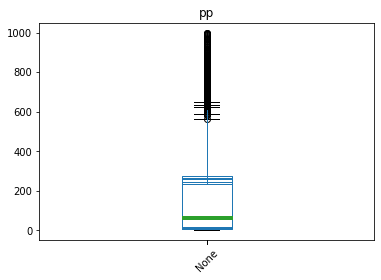

In [104]:
for i in range(len(phase)):
    print(phase[i])
    sr1 = r[i] + r_itemcf[i]
#     sr1 = r_itemcf[i] + r[i]
    val1(sr1, 1000, all_click_df[phase[i]][1])
    

In [53]:
# s.to_pickle(os.path.join(args.DATA_DIR, 'data_gen/s_train_itemcf.pkl'))

### test

In [9]:
from multiprocessing import Pool
pool = Pool(args.now_phase+1)
ft = partial(t, mode='test', window=20)
r = pool.map(ft, range(args.now_phase+1))

2020-05-25 17:04:18.125 | INFO     | __main__:t:23 - load cocur_matr 0
2020-05-25 17:04:18.129 | INFO     | __main__:t:23 - load cocur_matr 2
2020-05-25 17:04:18.195 | INFO     | __main__:t:23 - load cocur_matr 1
2020-05-25 17:04:18.321 | INFO     | __main__:t:23 - load cocur_matr 4
2020-05-25 17:04:18.405 | INFO     | __main__:t:23 - load cocur_matr 3
2020-05-25 17:04:18.784 | INFO     | __main__:t:23 - load cocur_matr 5
2020-05-25 17:04:19.268 | INFO     | __main__:t:23 - load cocur_matr 6
2020-05-25 17:04:20.483 | INFO     | __main__:t:39 - recall_from_cocur_matr test 0
2020-05-25 17:04:20.540 | INFO     | __main__:t:39 - recall_from_cocur_matr test 1
2020-05-25 17:04:20.550 | INFO     | __main__:t:39 - recall_from_cocur_matr test 2
2020-05-25 17:04:20.953 | INFO     | __main__:t:39 - recall_from_cocur_matr test 4
2020-05-25 17:04:21.217 | INFO     | __main__:t:39 - recall_from_cocur_matr test 3
2020-05-25 17:04:22.471 | INFO     | __main__:t:39 - recall_from_cocur_matr test 5
2020-

In [10]:
s = pd.Series()
for i in range(args.now_phase+1):
    s = s.append(r[i])
    
sub = pd.DataFrame()

for i in range(50):
    sub[f'c{i}'] = s.str.get(i).str.get(0)

sub.applymap(int).to_csv('/Users/luoyonggui/Downloads/baseline1_itemcf66.csv', header=False)

In [76]:
s.str.len().value_counts()

500    8170
196      82
195      40
290      24
289      22
       ... 
65        1
41        1
33        1
109       1
40        1
Length: 461, dtype: int64

In [73]:
sub.applymap(int).to_csv('/Users/luoyonggui/Downloads/baseline1_itemcf64.csv', header=False)

ValueError: ('cannot convert float NaN to integer', 'occurred at index c28')

# model nn

## 导入库

In [157]:
import random
import numpy as np
from tqdm import tqdm
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

## 读取数据

In [114]:
whole_click_train, whole_click_val, click_test, test_qtime = load_whole_click_data(args.now_phase, args.DATA_DIR)

2020-05-24 18:53:19.892 | INFO     | code.eda:load_whole_click_data:54 - phase: 0
2020-05-24 18:53:20.172 | INFO     | code.eda:load_whole_click_data:54 - phase: 1
2020-05-24 18:53:20.460 | INFO     | code.eda:load_whole_click_data:54 - phase: 2
2020-05-24 18:53:20.757 | INFO     | code.eda:load_whole_click_data:54 - phase: 3
2020-05-24 18:53:21.100 | INFO     | code.eda:load_whole_click_data:54 - phase: 4
2020-05-24 18:53:21.470 | INFO     | code.eda:load_whole_click_data:54 - phase: 5
2020-05-24 18:53:21.863 | INFO     | code.eda:load_whole_click_data:54 - phase: 6
2020-05-24 18:53:29.900 | INFO     | code.eda:load_whole_click_data:84 - whole_click_train: (954588, 4), whole_click_val: (12081, 4), click_test: (175274, 4), test_qtime: (12081, 3)


In [124]:
whole_click = whole_click_train.append(whole_click_val)

In [134]:
user_feat = get_user_data()

In [115]:
item_feat = get_item_data()

In [ ]:
whole_click.loc[~whole_click.user_id.isin(user_feat.user_id), 'user_id'].tolist()

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(item_feat.iloc[:, 1:])

item_feat.iloc[:, 1:] = scaler.transform(item_feat.iloc[:, 1:])

In [135]:
dft = pd.DataFrame()

dft['user_id'] = whole_click.loc[~whole_click.user_id.isin(user_feat.user_id), 'user_id'].unique().tolist()
dft['user_age_level'] = ''
dft['user_gender'] = ''
dft['user_city_level'] = ''

In [137]:
user_feat = user_feat.append(dft, ignore_index=True)

In [138]:
user_feat.shape

(32245, 4)

In [117]:
user_feat.head()

,user_id,user_age_level,user_gender,user_city_level
0,17,8,M,4
1,26,7,M,2
2,35,6,F,4
3,40,6,M,1
4,49,6,M,1


In [121]:
item_feat.head()

,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,42844,1.757887,-1.102202,-0.222023,1.575777,-0.736294,-0.168443,-0.051297,1.292102,-1.863637,0.122845,0.121319,0.516905,-1.193824,0.189392,2.478445,0.412654,0.590463,-1.778120,-0.182573,-0.525687,0.844209,0.017419,-1.115269,-0.708528,0.106707,0.490688,-2.188021,-0.081683,-1.391624,0.291258,0.958997,0.045490,2.991187,1.561606,1.793469,1.150937,1.878136,-0.970536,-0.984191,1.551317,0.474756,0.914999,-1.354062,-1.495628,-0.643347,-1.667325,0.323319,0.531047,0.737569,...,-0.195995,1.444276,-0.072901,-0.649905,0.313999,0.988210,-0.742056,0.822419,0.413943,-0.523966,0.065430,1.101006,0.419622,0.656972,0.506902,-0.520453,-0.740179,0.218208,0.464606,-0.310160,-0.139749,0.813226,-0.256569,0.956343,0.706974,1.194861,-0.077909,-0.663368,0.870748,1.940528,0.026493,0.518132,-0.527107,0.472771,0.963207,0.769440,0.503484,-0.332108,0.052038,0.863489,-1.786997,-0.056063,-1.056496,-0.952991,0.031248,-0.152827,-0.978874,0.416639,0.195811,0.423983
1,67898,-1.991244,-0.326516,-0.044938,0.515855,0.126385,-1.246482,0.941128,0.369639,-0.077474,-1.062310,0.632865,0.164666,-0.173332,1.115121,-0.520361,-0.847728,-1.042623,-0.056352,0.944852,1.635520,-0.599170,1.156619,0.436259,0.267531,1.075779,-0.211385,-0.000299,0.345218,-0.341474,-1.053010,1.513930,0.653496,-0.469300,1.745750,0.987036,0.233495,1.047592,-1.159734,0.511048,-0.522723,0.477134,1.437587,-0.652003,-1.404134,-0.084294,0.686014,-0.904300,1.039448,1.496823,...,1.124889,0.736584,0.545674,-0.009513,-1.045850,-0.668804,0.423577,0.171897,-0.275322,-0.681048,0.548542,-1.232298,-0.212655,0.004834,-0.140794,-0.092054,-0.245032,1.046985,1.073848,-0.769670,-0.949525,-0.597863,0.085385,0.776866,-0.633360,0.389113,-0.598649,-0.323668,0.895281,-0.135952,-1.063844,1.065588,0.598996,0.751578,-1.139146,0.487528,0.195173,-0.150884,-0.689160,1.808602,-0.216371,-0.787458,0.607339,1.105438,-0.344081,0.401650,0.457390,-0.167607,0.804866,-0.355152
2,66446,1.589194,-0.629173,0.165136,-0.293160,-2.015595,-0.534387,-0.391392,1.084667,-1.587032,-0.602641,0.629585,1.211532,1.398032,0.914748,1.689658,-0.638989,0.124860,-1.234778,0.925952,0.506249,0.799338,-1.057054,-0.649090,-1.383398,2.216329,-0.062202,-1.679064,1.023956,-2.058138,-0.317508,1.004609,-0.923267,2.105826,0.936795,1.615587,0.249596,0.350635,-1.605186,-0.075343,1.809761,0.214070,1.271264,-0.591021,-1.518127,-0.151818,-1.391590,0.180595,1.398965,1.130181,...,-0.397193,1.634975,0.236203,-0.976741,-0.337350,1.099469,-0.012963,0.976539,1.190066,0.306125,-0.066792,0.032141,-0.948426,0.705798,0.730033,-1.349935,-0.160542,0.559426,-0.148436,0.412128,0.434860,0.754910,-0.398259,0.077673,0.453511,1.775609,0.580855,0.593825,-0.404105,1.737629,-0.203567,1.072538,-1.685195,0.500954,0.963277,-0.183290,-0.295843,0.348906,-0.215870,0.612916,-2.455906,0.239636,-1.458252,-0.392869,1.010882,-0.593637,-0.630557,0.898723,0.735422,0.604839
3,63651,0.689737,-0.332909,0.157773,-1.694496,0.260846,-0.427423,-0.242087,1.545983,-1.906077,0.164312,0.161314,-1.439781,0.815043,-1.076477,-0.769554,1.355076,1.303593,-2.506697,0.895472,-0.416600,-0.450126,-1.080963,-0.598757,1.110443,1.010119,-0.216244,0.417873,1.292479,-1.177823,1.024824,0.963735,-0.721188,0.196403,-0.077413,1.190113,1.239477,0.822925,0.611071,0.071331,0.822149,-0.310218,0.908125,-0.946190,-0.744488,0.490659,-0.974751,-0.009493,-0.878472,-0.551132,...,-0.857661,-0.728202,-0.312866,2.376894,0.166350,-0.321873,0.762008,-0.574143,-0.636547,-0.423706,0.519493,-0.418202,-0.206378,0.945352,-0.176698,1.279369,-1.224019,-0.732667,-0.419778,-0.196754,-1.600217,-0.980272,-0.605248,0.098911,0.192824,0.564383,-0.136827,-1.137518,-1.532485,0.659212,0.144643,-0.415301,-0.005349,-0.927885,0

In [139]:
data = pd.merge(pd.merge(whole_click, user_feat), item_feat, how='left').fillna(0)

In [140]:
data.head(2)

,user_id,item_id,time,phase,user_age_level,user_gender,user_city_level,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,20937,18599,0.9837396801944459,0,,,,0.811226,-1.48390,0.746492,-0.120709,-0.794183,-0.601859,-1.555688,1.071563,-1.565983,0.464742,-0.428925,-0.134833,0.974733,-0.321980,1.807831,0.273731,0.254560,1.068950,-0.830466,1.102259,1.469358,0.199100,0.436080,-2.283467,0.087652,0.107330,-0.474662,0.576498,0.807002,0.569363,-1.995715,-1.082803,1.831957,0.828099,1.226347,-1.633744,-0.399197,-0.622067,0.406685,1.217054,-0.325036,-0.659466,1.174622,...,-0.088702,-0.458953,0.764478,0.06441,-1.163438,-0.125429,-0.875543,-1.303627,-0.648196,-0.203832,1.111075,2.088377,0.076171,-1.330337,-1.413262,-0.886255,1.025749,-2.441591,-0.674358,-0.156571,1.406293,1.252510,1.636942,0.026711,-0.788347,-1.284699,1.639902,0.047802,-0.292799,0.095451,0.826738,-1.582769,0.839248,-0.058568,-0.350104,-0.409334,-0.030521,2.835000,1.062022,-0.557092,2.281608,0.339870,1.754804,-0.595972,-0.633797,1.891259,0.391874,-0.595641,-2.753087,-2.494867
1,20937,22347,0.9837397212021592,0,,,,-0.420350,0.17377,0.324621,-0.388966,0.275582,0.373824,-0.015866,0.004448,1.535325,-0.521550,0.117400,-0.989165,-0.271713,-0.846344,0.386347,0.584954,-0.457648,-0.034025,-0.388127,-0.982791,-0.015392,-0.842828,-0.196718,-0.228130,-0.280346,0.557374,-0.665598,0.727228,-0.385569,-0.654904,0.619760,0.414645,-0.669727,0.221897,-0.599206,1.057355,1.295849,1.039049,0.271463,0.324661,0.440983,0.456148,-0.526693,...,-1.098183,1.465218,0.065749,0.88422,1.647454,1.097397,-0.081731,-0.566832,1.535189,-0.055151,-0.718219,0.745564,0.219221,0.228327,1.214971,0.577839,-1.139813,0.601054,1.496479,-0.187817,-1.053451,2.416237,-1.468266,-0.803279,1.125454,1.644535,-0.361886,-1.171610,1.895155,2.201822,1.500008,-1.370672,1.911411,0.110649,1.709302,-0.305754,0.362295,-0.893818,0.955600,0.081006,-0.645720,-0.366016,-0.924536,-2.494429,0.462330,0.309782,-2.066297,-0.380410,-0.714194,0.284327


In [191]:
data.dtypes

user_id             int64
item_id             int64
time               object
phase               int64
user_age_level      int64
                   ...   
253               float64
254               float64
255               float64
text_vec           object
img_vec            object
Length: 265, dtype: object

In [142]:
data.iloc[:, 7]

0         0.811226
1        -0.420350
2        -1.109515
3        -0.587023
4        -0.027982
            ...   
966664    0.000000
966665    0.000000
966666   -1.077140
966667   -0.836746
966668   -0.073394
Name: 0, Length: 966669, dtype: float64

In [148]:
data.shape

(966669, 263)

In [149]:
data['text_vec'] = data.iloc[:, 7:135].values.tolist()

In [321]:
data['img_vec'] = data.iloc[:, 135:263].values.tolist()

In [322]:
data['img_vec']

0         [0.058432269913102255, 1.6413349887206417, 0.0...
105       [-1.0139648761099664, 0.7866344810713779, 0.13...
444       [0.05325211175279664, 1.6656685154230326, 1.14...
265       [-0.8425122025949419, 0.4003675743696562, 0.88...
454       [-1.493912877285195, -1.3664574922491854, 0.48...
                                ...                        
963861    [1.1977432475088057, -0.3648874047585577, -0.1...
327005    [-0.696504784589116, 0.640207032152778, -0.704...
445189    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
799215    [-0.5774964917360168, -0.18206543678153556, 1....
573379    [-0.9731073787712281, 0.42109031481407316, -0....
Name: img_vec, Length: 966669, dtype: object

In [323]:
data['img_vec'].str.len()

0         128
105       128
444       128
265       128
454       128
         ... 
963861    128
327005    128
445189    128
799215    128
573379    128
Name: img_vec, Length: 966669, dtype: int64

In [153]:
from sklearn.preprocessing import LabelEncoder

In [154]:
sparse_features = ['user_id',
                     'item_id',
#                      'time',
#                      'phase',
                     'user_age_level',
                     'user_gender',
                     'user_city_level',]
SEQ_LEN = 50
negsample = 0

# 1.Label Encoding for sparse features,and process sequence features with `gen_date_set` and `gen_model_input`

features = sparse_features + ['text_vec', 'img_vec']
feature_max_idx = {}
lbe_dict = {}
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature]) + 1
    feature_max_idx[feature] = data[feature].max() + 1
    lbe_dict[feature] = lbe

user_profile = data[["user_id", "user_age_level", "user_gender", "user_city_level"]].drop_duplicates('user_id')

item_profile = data[["item_id", 'text_vec', 'img_vec']].drop_duplicates('item_id').set_index("item_id")

user_profile.set_index("user_id", inplace=True)

user_item_list = data.groupby("user_id")['item_id'].apply(list)

In [324]:

item_profile = data[["item_id", 'text_vec', 'img_vec']].drop_duplicates('item_id').set_index("item_id")


## gen_data_set

In [155]:
def gen_data_set(data, negsample: int=0):
    """
    negsample: 负样本数相对于正样本数的倍数
    """
    data.sort_values("time", inplace=True)
    item_ids = data['item_id'].unique()

    train_set = []
    test_set = []
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        pos_list = hist['item_id'].tolist()  # 用户看过的电影列表

        if negsample > 0:
            # 产生负样本，策略：从用户没有评分的items中随机有放回采样
            candidate_set = list(set(item_ids) - set(pos_list))
            neg_list = np.random.choice(candidate_set,size=len(pos_list)*negsample,replace=True)
        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            if i != len(pos_list) - 1:
                # (user_id, items_list, next_item, label, items_list_length, next_item_rating)
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1,len(hist[::-1])))
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i*negsample+negi], 0,len(hist[::-1])))
            else:
                test_set.append((reviewerID, hist[::-1], pos_list[i],1,len(hist[::-1])))

    random.shuffle(train_set)
    random.shuffle(test_set)

    print(len(train_set[0]),len(test_set[0]))

    return train_set,test_set

In [391]:
negsample = 1
train_set, test_set = gen_data_set(data, negsample)

100%|██████████| 31525/31525 [20:21<00:00, 25.80it/s]  


5 5


In [392]:
train_seq = [line[1] for line in train_set]

## gen_model_input

In [188]:
item_profile

,text_vec,img_vec
item_id,,
22484,"[0.811226376274125, -1.4838997381459331, 0.746...","[0.058432269913102255, 1.6413349887206417, 0.0..."
41130,"[0.6402371781243269, -0.7982612734541634, 1.47...","[-1.0139648761099664, 0.7866344810713779, 0.13..."
50207,"[1.5066197418731062, -0.03246018432884947, -0....","[0.05325211175279664, 1.6656685154230326, 1.14..."
31509,"[1.5529735670991445, -1.0115644343781065, 1.48...","[-0.8425122025949419, 0.4003675743696562, 0.88..."
85521,"[1.532792218430754, 0.30135972364094665, 0.787...","[-1.493912877285195, -1.3664574922491854, 0.48..."
...,...,...
19583,"[-1.5670257993369965, 2.5582219065446545, -0.9...","[1.0928959502092215, -1.8183068300063134, 1.42..."
39759,"[0.03855492135689548, 0.4319835416978182, -0.6...","[0.8722817728146214, -0.5778395944016497, -0.9..."
31221,"[0.7584265275124287, 0.7180432968013596, 0.207...","[-1.0585273938263111, -0.4460675581030717, 0.5..."


In [393]:
def gen_model_input(train_set,user_profile,seq_max_len):

#     train_uid = np.array([line[0] for line in train_set])
#     train_seq = [line[1] for line in train_set]
#     train_iid = np.array([line[2] for line in train_set])
#     train_label = np.array([line[3] for line in train_set])
#     train_hist_len = np.array([line[4] for line in train_set])
    
    train_uid = [line[0] for line in train_set]
    train_seq = [line[1] for line in train_set]
    train_iid = [line[2] for line in train_set]
    train_label = [line[3] for line in train_set]
    train_hist_len = [line[4] for line in train_set]

    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0).tolist()
    train_model_input = {"user_id": train_uid, "item_id": train_iid, "hist_item_id": train_seq_pad,
                         "hist_len": train_hist_len}

    for key in ["user_age_level", "user_gender", "user_city_level"]:
        train_model_input[key] = user_profile.loc[train_model_input['user_id']][key].values.tolist()
        
    for key in ['text_vec', 'img_vec']:
        train_model_input[key] = item_profile.loc[train_model_input['item_id']][key].values.tolist()

    return train_model_input,train_label

In [394]:
SEQ_LEN = 50

In [395]:
train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)

## build nn 

In [169]:
feature_max_idx

{'user_id': 31526,
 'item_id': 98770,
 'user_age_level': 10,
 'user_gender': 4,
 'user_city_level': 8}

In [211]:
item_id_hist_list_len = SEQ_LEN
embed_dim = 64
uid_max = feature_max_idx['user_id']
age_max = feature_max_idx['user_age_level']
city_max = feature_max_idx['user_city_level']
gender_max = feature_max_idx['user_gender']
item_id_max = feature_max_idx['item_id']

In [212]:
import tensorflow as tf

In [351]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_city = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_city')

    item_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='item_id') 
    item_id_hist_list = tf.keras.layers.Input(shape=(item_id_hist_list_len,), dtype='int32', name='item_id_hist_list') 
    item_text_vec = tf.keras.layers.Input(shape=(128,), dtype='float', name='item_text_vec') 
    item_img_vec = tf.keras.layers.Input(shape=(128,), dtype='float', name='item_img_vec')  
#     item_text_vec = tf.keras.layers.Input(shape=(128,), name='item_text_vec') 
#     item_img_vec = tf.keras.layers.Input(shape=(128,), name='item_img_vec') 
    return uid, user_gender, user_age, user_city, item_id, item_id_hist_list, item_text_vec, item_img_vec

In [352]:
def get_user_embedding(uid, user_gender, user_age, user_city):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)  # (batch_size, 1, embed_dim)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    city_embed_layer = tf.keras.layers.Embedding(city_max, embed_dim // 2, input_length=1, name='city_embed_layer')(user_city)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, city_embed_layer

In [353]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, city_embed_layer):
    #第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)  # (batch_size, 1, embed_dim)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    city_fc_layer = tf.keras.layers.Dense(embed_dim, name="city_fc_layer", activation='relu')(city_embed_layer)

    #第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, city_fc_layer], 2)  #(batch_size, 1, embed_dim*4)
    user_combine_layer = tf.keras.layers.Dense(200, activation='relu')(user_combine_layer)  #(batch_size, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape((200,), name="user_combine_layer_flat")(user_combine_layer) #(batch_size, 200)
    return user_combine_layer_flat

In [354]:
def get_item_embeding(item_id, item_id_hist_list):
    item_embed_layer = tf.keras.layers.Embedding(item_id_max, embed_dim, name='item_embed_layer')
    item_id_embed_layer = item_embed_layer(item_id)
    item_id_hist_list_embed_layer = item_embed_layer(item_id_hist_list)  # (batch_size, step, embed_dim)
    return item_id_embed_layer, item_id_hist_list_embed_layer

In [355]:
def get_item_feature_layer(item_id_embed_layer, item_id_hist_list_embed_layer, item_text_vec, item_img_vec):
    item_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="item_id_fc_layer", activation='relu')(item_id_embed_layer)  # (batch_size, 1, embed_dim)
    item_id_fc_layer = tf.keras.layers.Reshape((embed_dim,), name="item_id_fc_flat_layer")(item_id_fc_layer)
    item_id_hist_list_pool_layer = tf.keras.layers.GlobalAveragePooling1D()(item_id_hist_list_embed_layer)  # (batch_size, embed_dim)
    item_text_vec_fc_layer = tf.keras.layers.Dense(embed_dim, name="item_text_vec_fc_layer", activation='relu')(item_text_vec)  # (batch_size, embed_dim)
    item_img_vec_fc_layer = tf.keras.layers.Dense(embed_dim, name="item_img_vec_fc_layer", activation='relu')(item_img_vec)
    item_combine_layer = tf.keras.layers.concatenate([item_id_fc_layer, item_id_hist_list_pool_layer, item_text_vec_fc_layer, item_img_vec_fc_layer], 1)  # (batch_size, embed_dim+embed_dim+embed_dim+embed_dim)
    item_combine_layer = tf.keras.layers.Dense(200, activation='relu')(item_combine_layer)
    return item_combine_layer

In [356]:
uid, user_gender, user_age, user_city, item_id, item_id_hist_list, item_text_vec, item_img_vec = get_inputs()

In [357]:
uid_embed_layer, gender_embed_layer, age_embed_layer, city_embed_layer = get_user_embedding(uid, user_gender, user_age, user_city)
user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, city_embed_layer)
item_id_embed_layer, item_id_hist_list_embed_layer = get_item_embeding(item_id, item_id_hist_list)
item_combine_layer = get_item_feature_layer(item_id_embed_layer, item_id_hist_list_embed_layer, item_text_vec, item_img_vec)

In [358]:
user_item_combine_layer = tf.keras.layers.concatenate([user_combine_layer_flat, item_combine_layer], 1)

In [359]:
predictions = tf.keras.layers.Dense(2, activation='softmax')(user_item_combine_layer)

model = tf.keras.Model(
    inputs=[uid, user_gender, user_age, user_city, item_id, item_id_hist_list, item_text_vec, item_img_vec],
    outputs=predictions)

# model.summary()

In [360]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
uid (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_gender (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_age (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_city (InputLayer)          [(None, 1)]          0                                            
____________________________________________________________________________________________

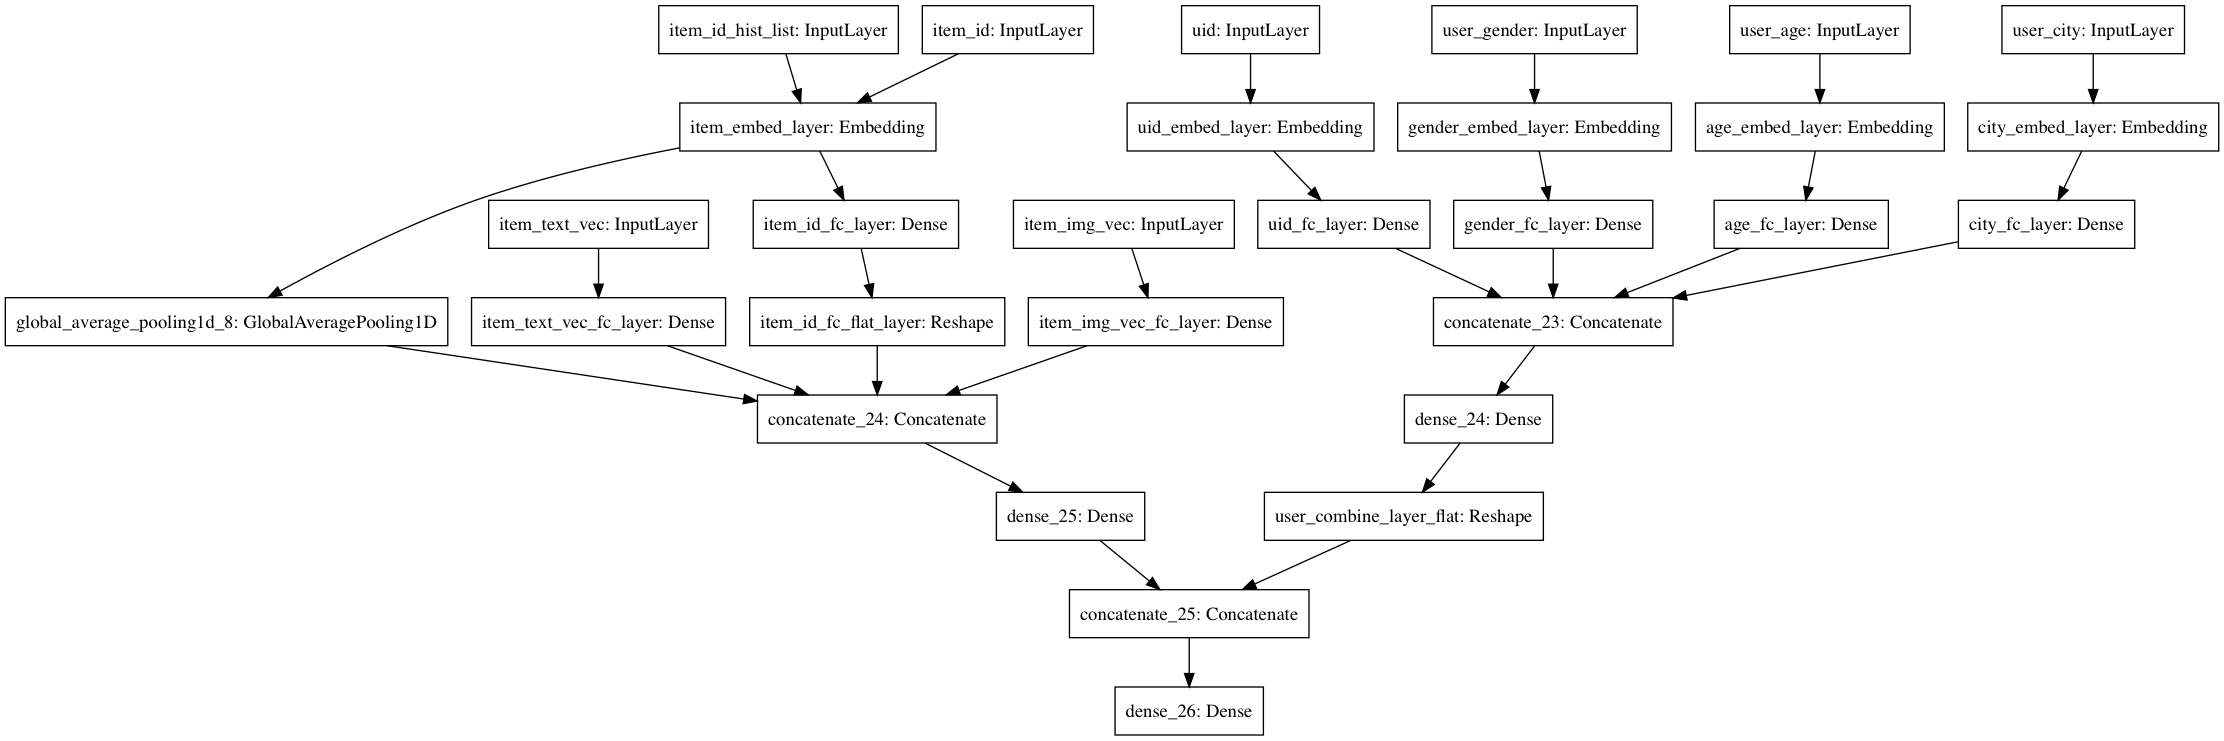

In [361]:
tf.keras.utils.plot_model(model)

In [362]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## fit

In [377]:
def data_generator():
    for i in range(len(train_model_input['user_id'])):
        yield [
    np.array(train_model_input['user_id'][:i]),
    np.array(train_model_input['user_gender'][:i]),
    np.array(train_model_input['user_age_level'][:i]),
    np.array(train_model_input['user_city_level'][:i]),
    np.array(train_model_input['item_id'][:i]),
    np.array(train_model_input['hist_item_id'][:i]),
    np.array(train_model_input['text_vec'][:i]),
    np.array(train_model_input['img_vec'][:i]),
          
          ], np.array(train_label[:i])

In [378]:
gen = data_generator()

In [380]:
for i in gen:
    print(i)

([array([29282]), array([1]), array([1]), array([1]), array([73331]), array([[92731, 62587, 96277, 86948, 50730,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]]), array([[ 3.66058804e-01, -4.92350901e-01, -1.17294662e+00,
        -9.31865381e-01,  1.61753274e+00,  1.46873988e+00,
         1.85543899e+00, -6.52703849e-01, -8.59137728e-02,
         1.95267296e-01,  4.06888357e-01, -6.35133329e-02,
        -5.03684976e-01, -1.10051864e+00, -1.79273551e+00,
        -5.03046642e-01, -9.88241603e-03, -5.35445343e-01,
         9.56695246e-01,  1.35106977e+00,  5.41454968e-01,
         6.32768025e-01,  1.01831296e+00,  1.58829662e+00,
         1.44247831e-01, -1.48601093e+00,  1.38530901e+00

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 2, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1,
       1, 5, 1, 1, 1, 6, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1,
       6, 1, 1, 4, 1, 3, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 1,
       1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       6, 1, 1, 2, 1, 5, 1]), array([73331, 23614, 38987, 13692, 90178, 85133, 12753, 13556, 69662,

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

([array([29282,  3512,   394,   861, 12098, 14171, 28576, 10015, 30889,
       30695, 13339, 11660, 17624, 21886, 27095,   321,  7435, 27143,
        5001, 22034, 19515, 31087,  2697,  6815, 26887,   909, 19383,
        3509,  2256, 20890, 16840, 14539,  6646,  9390, 12216, 24941,
       12858, 24746, 28937, 11594, 22535, 24287, 12216, 11381,  7225,
       28810, 15327,  5015,    52, 22713,  9404, 12263, 19491,  4273,
       21627, 27756,  8679, 21073, 28615, 28991, 31214, 22134,  4560,
       26717, 13179, 15017, 19015, 13241, 16258, 27551, 17093,  6792,
       10466, 24946,  2352,   748,  9505, 13774, 16091, 17504, 15609,
       18197,  7913, 17228, 20442,   622, 18499, 10666, 27195, 31483,
        9935,  2083,  8268,  9244,  1981,  9493,  3052,  9863, 29422,
       29959,  3787, 21277,  7567, 26787, 27964,  5877, 29909,   835,
        3656,  2876, 17584, 15186, 19039, 17176, 12409, 30266,  4681,
       18940,    60, 25759, 24916,  3242,  8645,  2125, 11555,  3450,
       20708, 1463

KeyboardInterrupt: 

In [261]:
train_model_input.keys()

dict_keys(['user_id', 'item_id', 'hist_item_id', 'hist_len', 'user_age_level', 'user_gender', 'user_city_level', 'text_vec', 'img_vec'])

In [ ]:
uid, user_gender, user_age, user_city, item_id, item_id_hist_list, item_text_vec, item_img_vec

In [396]:
# num = 100000
num = len(train_model_input['user_id'])  # 903619

a = [
    np.array(train_model_input['user_id'][:num]),
    np.array(train_model_input['user_gender'][:num]),
    np.array(train_model_input['user_age_level'][:num]),
    np.array(train_model_input['user_city_level'])[:num],
    np.array(train_model_input['item_id'][:num]),
    np.array(train_model_input['hist_item_id'][:num]),
    np.array(train_model_input['text_vec'][:num]),
    np.array(train_model_input['img_vec'][:num]),
          
          ]

b = np.array([(0, 1) for i in train_label[:num]])

In [397]:
model.fit(a, b, batch_size=128, epochs=2, validation_split=0.01)

Epoch 1/2
  996/13978 [=>............................] - ETA: 17:28 - loss: 6.6038e-08 - accuracy: 1.0000

KeyboardInterrupt: 

# 鱼佬开源

In [11]:
args.DATA_DIR

'../../data/contest/kdd_debiasing'

In [14]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import math

def get_sim_item(df_, user_col, item_col, use_iif=False): 

    df = df_.copy()
    user_item_ = df.groupby(user_col)[item_col].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))
    
    user_time_ = df.groupby(user_col)['time'].agg(list).reset_index() # 引入时间因素
    user_time_dict = dict(zip(user_time_[user_col], user_time_['time']))
    
    sim_item = {}  
    item_cnt = defaultdict(int)  # 商品被点击次数
    for user, items in tqdm(user_item_dict.items()):  
        for loc1, item in enumerate(items):  
            item_cnt[item] += 1  
            sim_item.setdefault(item, {})  
            for loc2, relate_item in enumerate(items):  
                if item == relate_item:  
                    continue  
                t1 = user_time_dict[user][loc1] # 点击时间提取
                t2 = user_time_dict[user][loc2]
                sim_item[item].setdefault(relate_item, 0)  
                if not use_iif:  
                    if loc1-loc2>0:
                        sim_item[item][relate_item] += 1 * 0.7 * (0.8**(loc1-loc2-1)) * (1 - (t1 - t2) * 10000) / math.log(1 + len(items)) # 逆向
                    else:
                        sim_item[item][relate_item] += 1 * 1.0 * (0.8**(loc2-loc1-1)) * (1 - (t2 - t1) * 10000) / math.log(1 + len(items)) # 正向
#                 else:  
#                     sim_item[item][relate_item] += 1 / math.log(1 + len(items))  

    sim_item_corr = sim_item.copy() # 引入AB的各种被点击次数  
    for i, related_items in tqdm(sim_item.items()):  
        for j, cij in related_items.items():  
#             sim_item_corr[i][j] = cij / ((item_cnt[i] * item_cnt[j]) ** 0.2)  
            sim_item_corr[i][j] = cij / (np.log(item_cnt[i]+1) * np.log(item_cnt[j]+1))
    return sim_item_corr, user_item_dict  


def recommend(sim_item_corr, user_item_dict, user_id, top_k, item_num):  
    '''
    input:item_sim_list, user_item, uid, 500, 50
    # 用户历史序列中的所有商品均有关联商品,整合这些关联商品,进行相似性排序
    '''
    rank = {}  
    interacted_items = user_item_dict[user_id] 
    interacted_items = interacted_items[::-1]
    for loc, i in enumerate(interacted_items):  
        for j, wij in sorted(sim_item_corr[i].items(), key=lambda d: d[1], reverse=True)[0:top_k]:  
            if j not in interacted_items:  
                rank.setdefault(j, 0)  
                rank[j] += wij * (0.7**loc) 

    return sorted(rank.items(), key=lambda d: d[1], reverse=True)[:item_num]  

# fill user to 50 items  
def get_predict(df, pred_col, top_fill):  
    top_fill = [int(t) for t in top_fill.split(',')]  
    scores = [-1 * i for i in range(1, len(top_fill) + 1)]  
    ids = list(df['user_id'].unique())  
    fill_df = pd.DataFrame(ids * len(top_fill), columns=['user_id'])  
    fill_df.sort_values('user_id', inplace=True)  
    fill_df['item_id'] = top_fill * len(ids)  
    fill_df[pred_col] = scores * len(ids)  
    df = df.append(fill_df)  
    df.sort_values(pred_col, ascending=False, inplace=True)  
    df = df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')  
    df['rank'] = df.groupby('user_id')[pred_col].rank(method='first', ascending=False)  
    df = df[df['rank'] <= 50]  
    df = df.groupby('user_id')['item_id'].apply(lambda x: ','.join([str(i) for i in x])).str.split(',', expand=True).reset_index()  
    return df  

now_phase = 6
train_path = '../../data/contest/kdd_debiasing/data_gen/underexpose_train'  
test_path = '../../data/contest/kdd_debiasing/data_gen/underexpose_test'  
recom_item = []  

whole_click = pd.DataFrame()  
for c in range(now_phase + 1):  
    print('phase:', c)  
    click_train = pd.read_csv(train_path + '/underexpose_train_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'])  
    click_test = pd.read_csv(test_path + '/underexpose_test_click-{}/underexpose_test_click-{}.csv'.format(c,c), header=None,  names=['user_id', 'item_id', 'time'])  

    all_click = click_train.append(click_test)  
    whole_click = whole_click.append(all_click)  
    whole_click = whole_click.drop_duplicates(subset=['user_id','item_id','time'],keep='last')
    whole_click = whole_click.sort_values('time')

    item_sim_list, user_item = get_sim_item(whole_click, 'user_id', 'item_id', use_iif=False)  

    for i in tqdm(click_test['user_id'].unique()):  
        rank_item = recommend(item_sim_list, user_item, i, 500, 500)  
        for j in rank_item:  
            recom_item.append([i, j[0], j[1]])  
            
# find most popular items  
top50_click = whole_click['item_id'].value_counts().index[:50].values  
top50_click = ','.join([str(i) for i in top50_click])  

recom_df = pd.DataFrame(recom_item, columns=['user_id', 'item_id', 'sim'])  
result = get_predict(recom_df, 'sim', top50_click)  
result.to_csv('/Users/luoyonggui/Downloads/baseline4.csv', index=False, header=None)



phase: 0


100%|██████████| 1663/1663 [00:08<00:00, 200.99it/s]


phase: 1


100%|██████████| 1726/1726 [00:15<00:00, 111.30it/s]


phase: 2


100%|██████████| 1690/1690 [00:22<00:00, 76.62it/s] 


phase: 3


100%|██████████| 1675/1675 [00:33<00:00, 49.35it/s] 


phase: 4


100%|██████████| 1708/1708 [00:52<00:00, 32.43it/s] 


phase: 5


100%|██████████| 1798/1798 [01:07<00:00, 26.80it/s] 


phase: 6


100%|██████████| 1821/1821 [01:25<00:00, 21.32it/s] 
